In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("/scr-ssd/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = load_from_disk("../../experiments/RAVEL/data/city_country_train")
test_dataset = load_from_disk("../../experiments/RAVEL/data/city_country_test")

collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True, contain_entity_position=True, source_suffix_visibility=False, base_suffix_visibility=False)
dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/scr-ssd/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=True
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/scr-ssd/sjd24/city_symmetric/model_epoch_2_step_3450")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

In [5]:
from analysis_utils import get_run_data, get_max_weight_type

# dataset = get_run_data(hypernetwork, tokenizer, test_dataset)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
from analysis_utils import get_entity_positions, get_example_max_weight_coord, get_max_weight_type, get_run_data
import pandas as pd

sym_df = pd.DataFrame(columns=["Attribute", "Source Position", "Source Subject Token Number", "Base Position", "Base Subject Token Number"])

for attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:
    
    print(f"Attribute: {attribute}")
    test_set = load_from_disk(f"./data/city_{attribute.lower()}_test")
    test_set = get_run_data(hypernetwork, tokenizer, test_set)
    
    for d in test_set:
        
        weight = d["intervention_weight"]
        
        (source_entity_position_ids, source_entity_token), (base_entity_position_ids, base_entity_token) = get_entity_positions(d, tokenizer)
        selected_weight = weight[source_entity_position_ids, :]
        selected_weight = selected_weight[:, base_entity_position_ids]
        
        source_coord, base_coord = get_example_max_weight_coord(d, tokenizer)
        
        source_position, base_positon = None, None
        source_tkn_num = len(source_entity_position_ids)
        base_entity_token = len(base_entity_position_ids)
        
        source_intervention_token_type, _, base_intervention_token_type , _ = get_max_weight_type(d, tokenizer)        
        
        if source_coord not in source_entity_position_ids:
            if source_intervention_token_type == "Sentence Last Token":
                source_position = "Sentence Last Token"
            else:
                source_position = "Others"
        else:
            source_position = str(source_entity_position_ids.index(source_coord))
        
        if base_coord not in base_entity_position_ids:
            if base_intervention_token_type == "Sentence Last Token":
                base_position = "Sentence Last Token"
            else:
                base_position = "Others"
        else:
            base_position = str(base_entity_position_ids.index(base_coord))
            
        sym_df.loc[len(sym_df)] = [attribute, source_position, source_tkn_num, base_position, base_entity_token]

Attribute: Country


NameError: name 'get_run_data' is not defined

In [11]:
new_source_position_value = []
new_base_position_value = []

for i, row in df.iterrows():
    if row["Source Position"] == "Sentence Last Token":
        new_source_position_value.append("Sentence Last Token")
    elif row["Source Position"] == "Others":
        new_source_position_value.append(f"Others")
    elif row["Source Position"] == "0":
        new_source_position_value.append("1st Subject Token")
    elif row["Source Position"] == "1":
        new_source_position_value.append("2nd Subject Token")
    elif row["Source Position"] == "2":
        new_source_position_value.append("3rd Subject Token")
    else:
        new_source_position_value.append(f"{int(row['Source Position'])+1}th Subject Token")
        
    if row["Base Position"] == "Sentence Last Token":
        new_base_position_value.append("Sentence Last Token")
    elif row["Base Position"] == "Others":
        new_base_position_value.append(f"Others")
    elif row["Base Position"] == "0":
        new_base_position_value.append("1st Subject Token")
    elif row["Base Position"] == "1":
        new_base_position_value.append("2nd Subject Token")
    elif row["Base Position"] == "2":
        new_base_position_value.append("3rd Subject Token")
    else:
        new_base_position_value.append(f"{int(row['Base Position'])+1}th Subject Token")
        

In [12]:
df["Source Position"] = new_source_position_value
df["Base Position"] = new_base_position_value

/tmp/user/24141/ipykernel_3971491/1521375889.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend().remove()
/tmp/user/24141/ipykernel_3971491/1521375889.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
/tmp/user/24141/ipykernel_3971491/1521375889.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)


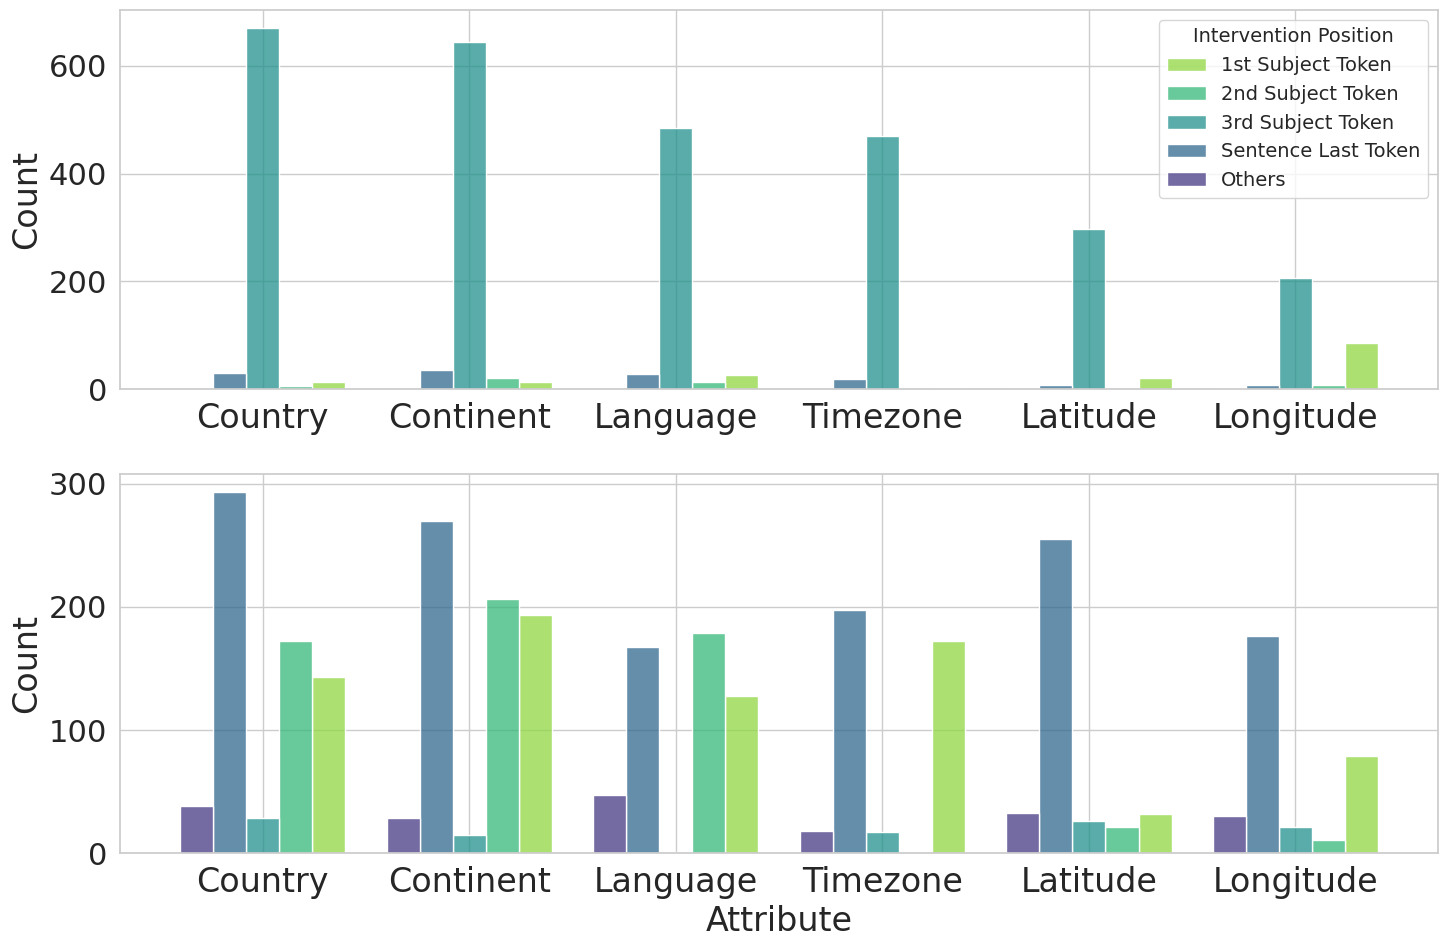

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=2)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

three_token_base_df = df[df["Base Subject Token Number"] == 3]
three_token_source_df = df[df["Source Subject Token Number"] == 3]
order = ["1st Subject Token", "2nd Subject Token", "3rd Subject Token", "Sentence Last Token", "Others"]

# Plot a histogram of the base position, grouped by "Attribute", add interval between each group
sns.histplot(data=three_token_source_df, x="Attribute", hue="Source Position", multiple="dodge", ax=axes[0], palette="viridis", hue_order=order, shrink=0.8)
sns.histplot(data=three_token_base_df, x="Attribute", hue="Base Position", multiple="dodge", ax=axes[1], palette="viridis", hue_order=order, shrink=0.8)

axes[0].set_xlabel("")
axes[1].legend().remove() 


for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
    
axes[0].legend(
    title="Intervention Position",
    title_fontsize=14,
    labels=["1st Subject Token", "2nd Subject Token", "3rd Subject Token", "Sentence Last Token", "Others"],
    fontsize=14,
    loc="upper right",
)

plt.tight_layout()
fig.savefig("subject_tkn_position.pdf")
